In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import os

from google.colab import drive
from skimage.io import imread
from skimage.transform import resize
import sys
from IPython.display import clear_output
import gc

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms

from matplotlib import rcParams

from time import time
import copy
from dataclasses import dataclass, asdict
import pickle

import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import random

from collections import Counter
from sklearn.metrics import classification_report

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

os.chdir(f'./Transformer-Explainability')

!pip install einops

fatal: destination path 'Transformer-Explainability' already exists and is not an empty directory.


# Load data

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar


--2024-12-15 21:12:48--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-12-15 21:12:48--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc57334cccc854c2a86a7434c3c6.dl.dropboxusercontent.com/cd/0/inline/CgUK-usPLJPg29C_9q7Wr2zTm_gJlXVEi7MzDCjKR2wC7wjxAbRkq7i9oNYwIVICHuYUMvXKTUXJWW5GUNbTIaVKKa4yaBwE5bkHch9BCTYhqY1Nd0LBh7ToToZrPEGg94Y/file# [following]
--2024-12-15 21:12:48--  https://uc57334cccc854c2a86a7434c3c6.dl.dropboxusercontent.com/cd/0/inline/CgUK-usPLJPg29C_

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
rcParams['figure.figsize'] = (15,4)

drive.mount('/content/drive', force_remount=True)
drive_path = "/content/Transformer-Explainability/PH2Dataset"
# drive_path = "Transformer-Explainability/PH2Dataset"

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

Mounted at /content/drive
cuda


Processing Directories: 100%|██████████| 627/627 [00:03<00:00, 160.84it/s]


Cleaned 200 images, 200 masks, and 200 labels.


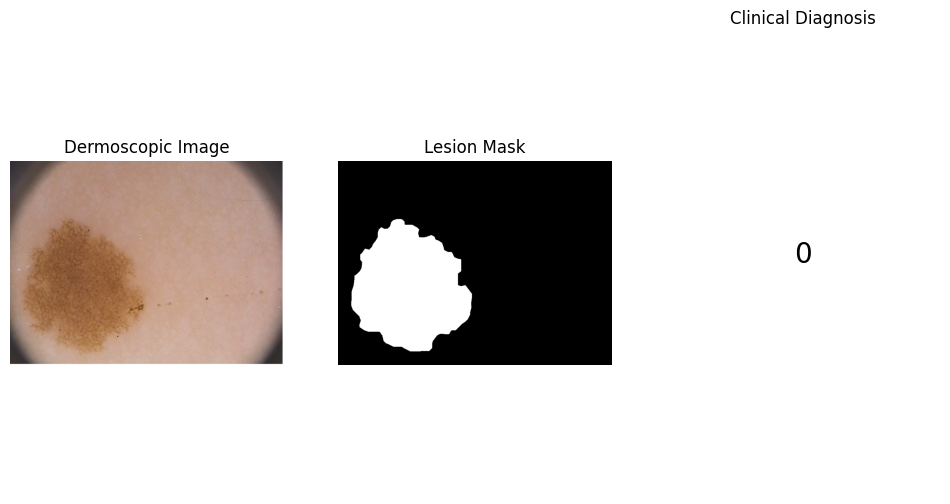

In [ ]:
# Paths
root_path = "/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images"
metadata_path = "/content/Transformer-Explainability/PH2Dataset/PH2_dataset.txt"

# root_path = r"C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset"
# metadata_path = r"C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_dataset.txt"

# Load metadata
metadata = pd.read_csv(metadata_path, sep="\\|", engine="python", skipinitialspace=True)
metadata.columns = metadata.columns.str.strip()  # Clean column names
metadata = metadata.dropna(how="all", axis=1)  # Drop empty columns
metadata = metadata[["Name", "Clinical Diagnosis"]]
metadata["Name"] = metadata["Name"].str.strip()  # Clean image names
metadata["Clinical Diagnosis"] = pd.to_numeric(metadata["Clinical Diagnosis"], errors="coerce")

# Remove rows with NaN in Clinical Diagnosis
metadata = metadata.dropna(subset=["Clinical Diagnosis"])
metadata["Clinical Diagnosis"] = metadata["Clinical Diagnosis"].astype(int)

# Initialize data storage
images = []
lesions = []
image_names = []

# Gather all directories in the root path
all_dirs = [os.path.join(root, d) for root, dirs, _ in os.walk(root_path) for d in dirs]

# Process directories
for directory in tqdm(all_dirs, desc="Processing Directories"):
    if directory.endswith('_Dermoscopic_Image'):
        # Load the first image file in the directory
        image_files = os.listdir(directory)
        if image_files:  # Ensure the directory is not empty
            image_name = os.path.basename(directory).replace('_Dermoscopic_Image', '')
            image_names.append(image_name)
            images.append(imread(os.path.join(directory, image_files[0])))
    if directory.endswith('_lesion'):
        # Load the first lesion file in the directory
        lesion_files = os.listdir(directory)
        if lesion_files:  # Ensure the directory is not empty
            lesions.append(imread(os.path.join(directory, lesion_files[0])))

# Match images, masks, and clinical diagnoses
matched_labels = []
matched_images = []
matched_lesions = []

for i, name in enumerate(image_names):
    label_row = metadata[metadata["Name"] == name]
    if not label_row.empty:
        matched_labels.append(label_row["Clinical Diagnosis"].values[0])
        matched_images.append(images[i] if i < len(images) else None)
        matched_lesions.append(lesions[i] if i < len(lesions) else None)

# Data Cleaning: Remove any unmatched or None entries
cleaned_images = []
cleaned_lesions = []
cleaned_labels = []

for img, lesion, label in zip(matched_images, matched_lesions, matched_labels):
    if img is not None and lesion is not None and not np.isnan(label):
        cleaned_images.append(img)
        cleaned_lesions.append(lesion)
        cleaned_labels.append(label)

# Check the cleaned data
print(f"Cleaned {len(cleaned_images)} images, {len(cleaned_lesions)} masks, and {len(cleaned_labels)} labels.")

# Plot a single sample
if cleaned_images and cleaned_lesions and cleaned_labels:
    sample_index = 0  # Choose the first sample for plotting

    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 3, 1)
    plt.imshow(cleaned_images[sample_index], cmap='gray')
    plt.title("Dermoscopic Image")
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 3, 2)
    plt.imshow(cleaned_lesions[sample_index], cmap='gray')
    plt.title("Lesion Mask")
    plt.axis('off')

    # Display the label
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, str(cleaned_labels[sample_index]), fontsize=20, ha='center')
    plt.title("Clinical Diagnosis")
    plt.axis('off')

    plt.show()
else:
    print("No valid samples to display.")


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(images, cleaned_labels, test_size=0.2, stratify=cleaned_labels, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

#print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Testing size: {len(X_test)}")

X_train = images
X_temp = images
y_train = cleaned_labels
y_temp = cleaned_labels


In [ ]:
from torchvision import transforms

class PH2Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Define data augmentation transformations for training
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize for ViT or CNN input
    #transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip image horizontally
    #transforms.RandomVerticalFlip(p=0.5),  # Randomly flip image vertically
    #transforms.RandomRotation(degrees=30),  # Rotate image randomly within ±30 degrees
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Adjust color
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
])

# Define validation/test transformations (no augmentations, only resizing and normalization)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = PH2Dataset(X_train, y_train, transform=train_transform)
val_dataset = PH2Dataset(X_temp, y_temp, transform=val_test_transform)
#test_dataset = PH2Dataset(X_test, y_test, transform=val_test_transform)
test_dataset = val_dataset
# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import numpy as np

import numpy as np
print(np.__version__)

# Function to count samples in each class
def count_class_samples(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    return class_counts

# Count samples in train and validation datasets
train_class_counts = count_class_samples(train_dataset)
val_class_counts = count_class_samples(val_dataset)

# Print class distributions
print("Training dataset class distribution:")
for class_id, count in sorted(train_class_counts.items()):
    print(f"  Class {class_id}: {count} samples")

print("Validation dataset class distribution:")
for class_id, count in sorted(val_class_counts.items()):
    print(f"  Class {class_id}: {count} samples")

1.26.4
Training dataset class distribution:
  Class 0: 80 samples
  Class 1: 80 samples
  Class 2: 40 samples
Validation dataset class distribution:
  Class 0: 80 samples
  Class 1: 80 samples
  Class 2: 40 samples


# Train model

In [ ]:
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP_new
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from torchvision import transforms


# Define training transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define validation/test transformations
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Update datasets with transformations
train_dataset.transform = train_transform
val_dataset.transform = val_test_transform


# Define class weights for imbalanced dataset
total_samples = sum(train_class_counts.values())
class_weights = [total_samples / train_class_counts[c] for c in range(3)]
class_weights = torch.tensor(class_weights).cuda()


# Weighted sampler for balanced sampling
sample_weights = [1 / train_class_counts[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Update DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model setup
model_A = vit_LRP_new(pretrained=True, num_classes=3).cuda()  # 3 classes: nevus, atypical nevus, melanoma
criterion_A = nn.CrossEntropyLoss(weight=class_weights)
optimizer_A = optim.AdamW(model_A.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_A = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_A, T_0=10, T_mult=2)

model_B = vit_LRP(pretrained=True, num_classes=3).cuda()  # 3 classes: nevus, atypical nevus, melanoma
criterion_B = nn.CrossEntropyLoss(weight=class_weights)
optimizer_B = optim.AdamW(model_B.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_B = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_B, T_0=10, T_mult=2)


def train_model(model, criterion, optimizer, scheduler):
  # Early stopping parameters
  best_accuracy = 0
  patience = 7
  early_stop_count = 0

  num_epochs = 25
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for images, labels in train_loader:
          images = images.cuda()
          labels = labels.long().cuda()


          outputs = model(images)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

      # Validation
      model.eval()
      correct, total = 0, 0
      y_true, y_pred = [], []
      for images, labels in val_loader:
          images = images.cuda()
          labels = labels.long().cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

      accuracy = 100 * correct / total
      print(f"Validation Accuracy: {accuracy:.2f}%")

      # Classification report
      if epoch == num_epochs - 1 or accuracy > best_accuracy:
          print("Classification Report:")
          print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

      # Early stopping
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          early_stop_count = 0
          torch.save(model.state_dict(), "best_model.pth")  # Save the best model
      else:
          early_stop_count += 1
          if early_stop_count >= patience:
              print("Early stopping triggered.")
              break

      scheduler.step()
  return model


In [ ]:
# train_model(model_A, criterion_A, optimizer_A, scheduler_A)
model_B = train_model(model_B, criterion_B, optimizer_B, scheduler_B)

Epoch 1, Loss: 0.8829
Validation Accuracy: 61.50%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.53      0.99      0.69        80
     Class 1       0.64      0.11      0.19        80
     Class 2       0.97      0.88      0.92        40

    accuracy                           0.61       200
   macro avg       0.71      0.66      0.60       200
weighted avg       0.66      0.61      0.54       200

Epoch 2, Loss: 0.5302
Validation Accuracy: 64.00%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.44      0.59        80
     Class 1       0.58      0.66      0.62        80
     Class 2       0.57      1.00      0.73        40

    accuracy                           0.64       200
   macro avg       0.68      0.70      0.65       200
weighted avg       0.71      0.64      0.63       200

Epoch 3, Loss: 0.4804
Validation Accuracy: 76.50%
Classification Report:
              preci

In [ ]:
torch.save(model_B.state_dict(), "best_model.pth")
state_dict = torch.load("best_model.pth")
model_A.load_state_dict(state_dict)

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

<ipython-input-13-7a15ca39e1d8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pth")


In [ ]:
def test_model_sample_by_sample(model, test_images, test_labels):
    model.eval()

    correct, total = 0, 0
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image
        transforms.ToTensor(),         # Convert to Tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
    ])

    for idx in range(len(test_images)):
        image = test_images[idx]
        label = test_labels[idx]

        # Ensure `image` is a NumPy array (if not already)
        if not isinstance(image, np.ndarray):
            raise TypeError(f"Expected image to be a numpy array, but got {type(image)}.")

        # Convert to PIL Image and apply transformations
        image = Image.fromarray(image).convert('RGB')  # Ensure RGB mode
        image = val_test_transform(image)  # Apply transformations
        image = image.cuda()  # Move to GPU
        label = torch.tensor(label).long().cuda()  # Ensure label is a LongTensor

        # Enable gradient computation
        image.requires_grad_()

        # Get model output
        outputs = model(image.unsqueeze(0))  # Add batch dimension during inference

        # Compute loss
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, label.unsqueeze(0))  # Add batch dimension to label

        loss.backward()

        # Get prediction
        _, predicted = torch.max(outputs, 1)

        # Update counters
        total += 1
        correct += (predicted.item() == label.item())

        # Log sample-specific details
        print(f"Sample {total}: Prediction = {predicted.item()}, GT Label = {label.item()}, Correct = {predicted.item() == label.item()}")

        gradients = image.grad
        print(f"Gradients shape for Sample {total}: {gradients.shape}")

    # Calculate accuracy
    test_accuracy = 100 * correct / total
    print(f"Total Correct: {correct}")
    print(f"Total Samples: {total}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
test_model_sample_by_sample(model_B, cleaned_images, cleaned_labels)

Sample 1: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 1: torch.Size([3, 224, 224])
Sample 2: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 2: torch.Size([3, 224, 224])
Sample 3: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 3: torch.Size([3, 224, 224])
Sample 4: Prediction = 1, GT Label = 1, Correct = True
Gradients shape for Sample 4: torch.Size([3, 224, 224])
Sample 5: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 5: torch.Size([3, 224, 224])
Sample 6: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 6: torch.Size([3, 224, 224])
Sample 7: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 7: torch.Size([3, 224, 224])
Sample 8: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 8: torch.Size([3, 224, 224])
Sample 9: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 9: torch.Size([3, 224, 224])
S

In [ ]:
test_model_sample_by_sample(model_A, cleaned_images, cleaned_labels)

Sample 1: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 1: torch.Size([3, 224, 224])
Sample 2: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 2: torch.Size([3, 224, 224])
Sample 3: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 3: torch.Size([3, 224, 224])
Sample 4: Prediction = 1, GT Label = 1, Correct = True
Gradients shape for Sample 4: torch.Size([3, 224, 224])
Sample 5: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 5: torch.Size([3, 224, 224])
Sample 6: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 6: torch.Size([3, 224, 224])
Sample 7: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 7: torch.Size([3, 224, 224])
Sample 8: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 8: torch.Size([3, 224, 224])
Sample 9: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 9: torch.Size([3, 224, 224])
S

In [ ]:
# create heatmap from mask on image
use_thresholding = True
CLS2IDX = {0: 'nevus',
 1: 'atypical nevus',
 2: 'melanoma'}

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


# from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
from baselines.ViT.ViT_explanation_generator import Baselines
from torchvision import transforms



b = Baselines(model_A)
attribution_generator = LRP(model_B)

def generate_visualization(original_image, class_index=None, method = "transformer_attribution"):
    class_index = class_index if class_index is not None else model_B(original_image.unsqueeze(0).cuda()).argmax().item()
    print(model_B(original_image.unsqueeze(0).cuda()).argmax().item())
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method=method, index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

"""# LRP"""
def generate_visualization_LRP(original_image, class_index=None, use_thresholding=False):
    class_index = class_index if class_index is not None else model_B(original_image.unsqueeze(0).cuda()).argmax().item()
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        _, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
    return vis

# Saliency
def generate_saliency_visualization(original_image, class_index=None, use_thresholding=False):
    original_image.requires_grad_()  # Enable gradient tracking for the input image

    # Forward pass through the model
    output = model_B(original_image.unsqueeze(0).cuda())

    # Select the class for which to compute saliency
    class_index = class_index if class_index is not None else output.argmax().item()
    loss = output[0, class_index]

    model_B.zero_grad()  # Clear previous gradients

    # Backpropagate the loss to compute gradients with respect to the input image
    loss.backward()

    # Compute the maximum gradient magnitude across color channels
    saliency = original_image.grad.data.abs().max(dim=0)[0]

    # Move the saliency map to the CPU and convert to a NumPy array
    saliency = saliency.cpu().numpy()

    # Normalize the saliency map to the range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Apply thresholding if specified
    if use_thresholding:
        saliency = saliency * 255
        saliency = saliency.astype(np.uint8)
        _, saliency = cv2.threshold(saliency, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        saliency[saliency == 255] = 1

    # Convert the input image to a NumPy array for visualization
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()

    # Normalize the input image
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())

    # Overlay the saliency map on the input image
    vis = show_cam_on_image(image_transformer_attribution, saliency)

    # Convert to BGR format for OpenCV
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)

    return vis

# Attention rollout visualization
def visualize_rollout_heatmap(input_image, start_layer=1, use_thresholding=False):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        _, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
    return vis

# CAM visualization
def visualize_CAM(input_image, class_index=None, use_thresholding=False):
    class_index = class_index if class_index is not None else model_B(input_image.unsqueeze(0).cuda()).argmax().item()
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        _, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
    return vis


def print_top_classes(predictions, **kwargs):
    # Print Top-3 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 3 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)


LRP

Predicted class: atypical nevus
Top 3 classes:
	1 : atypical nevus		value = 2.122	 prob = 92.5%
	0 : nevus         		value = -0.587	 prob = 6.2%
	2 : melanoma      		value = -2.072	 prob = 1.4%
1
1


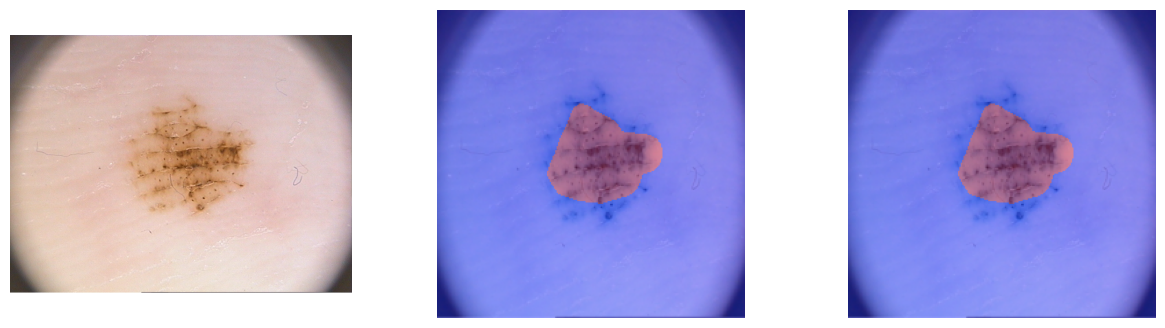

In [ ]:
image = Image.open('/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images/IMD008/IMD008_Dermoscopic_Image/IMD008.bmp')
# image = Image.open(r'C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset\IMD008\IMD008_Dermoscopic_Image\IMD008.bmp')

im = val_test_transform (image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model_B(im.unsqueeze(0).cuda())

# Get the predicted class index
_, predicted_class_idx = torch.max(output, dim=1)

# Map the predicted class index to its name
predicted_class_name = CLS2IDX[predicted_class_idx.item()]
print("Predicted class:", predicted_class_name)

print_top_classes(output)

# cat - the predicted class
class_0 = generate_visualization(im)


# generate visualization for class 243: 'bull mastiff'
class_1 = generate_visualization(im, class_index=1)


axs[1].imshow(class_0);
axs[1].axis('off');
axs[2].imshow(class_1);
axs[2].axis('off');

Attention Rollout

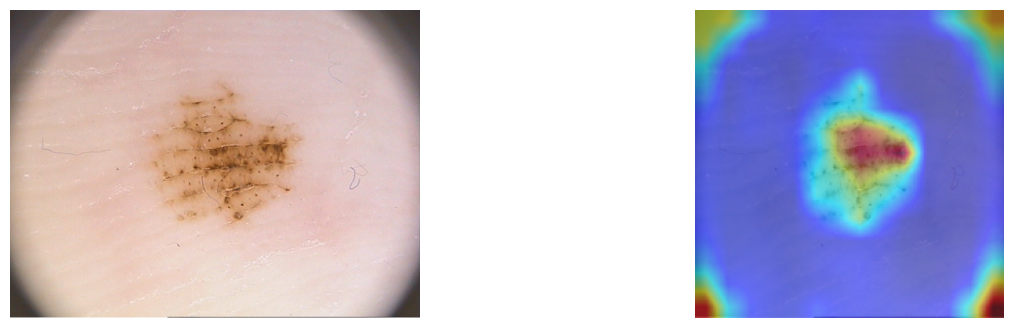

In [ ]:
class_0 = visualize_rollout_heatmap(im)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image);
axs[0].axis('off');
axs[1].imshow(class_0);
axs[1].axis('off');

CAM

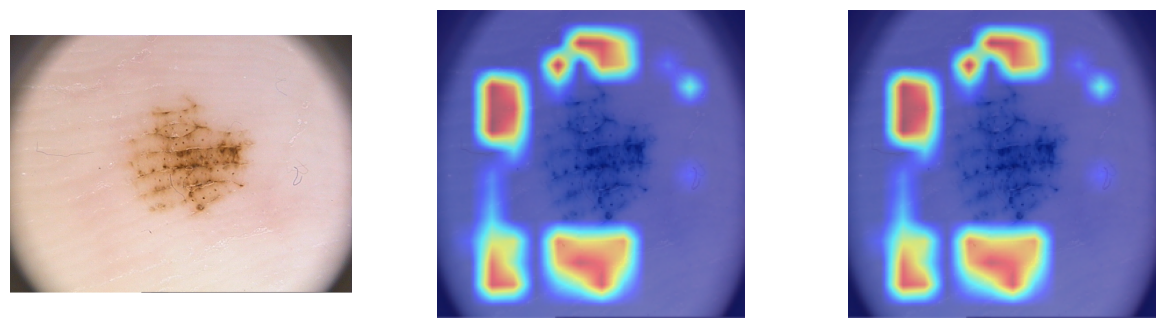

In [ ]:
class_0 = visualize_CAM(im)
class_1 = visualize_CAM(im, class_index=1)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');
axs[1].imshow(class_0);
axs[1].axis('off');
axs[2].imshow(class_1);
axs[2].axis('off');

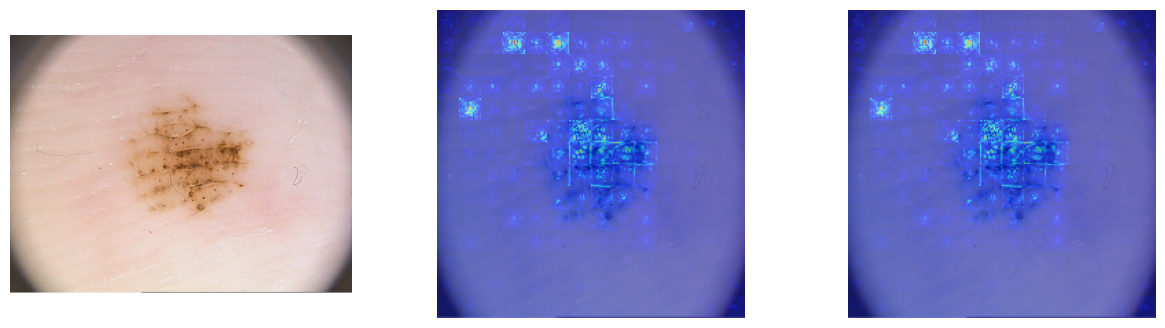

In [ ]:
class_0 = generate_saliency_visualization(im)
class_1 = generate_saliency_visualization(im, class_index=1)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');
axs[1].imshow(class_0);
axs[1].axis('off');
axs[2].imshow(class_1);
axs[2].axis('off');

# 1Way

Predicted class index: 0
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM


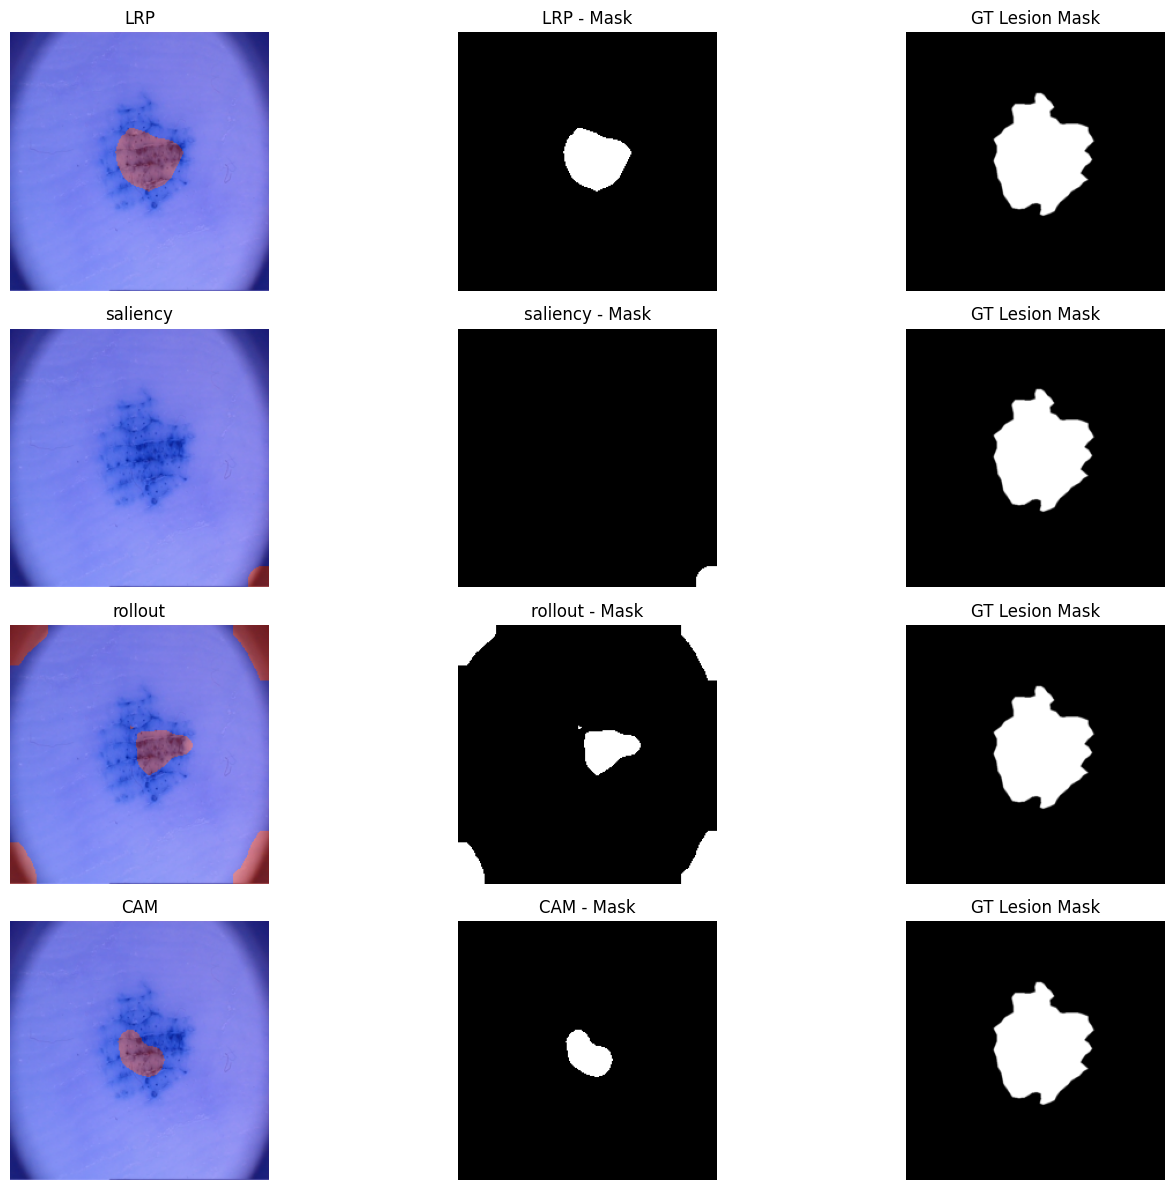

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

folder2='./test'
# Ensure the folder exists
os.makedirs(folder2, exist_ok=True)

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

def generate_LRP(original_image, class_index):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index):
    original_image.requires_grad_()
    output = model_B(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model_B.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=3):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method, use_thresholding=True):
    device = input_image.device
    attr = method(input_image).reshape(1, 1, 14, 14).to(device)

    combined_attr = torch.nn.functional.interpolate(attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

# Function to visualize each method with different combine methods
def visualize_methods(input_image, use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }

    # Determine the predicted class index
    output = model_A(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()
    print(f"Predicted class index: {class_index}")

    results = []
    for method_name, method_func in methods.items():
          print(f"Visualizing {method_name}")
          vis, mask = combine_and_visualize_attributions(input_image, lambda img: method_func(img, class_index), use_thresholding)
          results.append((f"{method_name}", vis, mask))

    return results

# Load images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_path = r'/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images/IMD008/IMD008_Dermoscopic_Image/IMD008.bmp'
mask_path = r'/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images/IMD008/IMD008_lesion/IMD008_lesion.bmp'

# image_path = r'C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset\IMD008\IMD008_Dermoscopic_Image\IMD008.bmp'
# mask_path = r'C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset\IMD008\IMD008_lesion\IMD008_lesion.bmp'
image = Image.open(image_path).convert('RGB')
lesion_mask = Image.open(mask_path).convert('L')

im = transform(image).cuda()
lesion_mask = transforms.Resize((224, 224))(lesion_mask)
lesion_mask = np.array(lesion_mask)

# Visualize methods
results = visualize_methods(im, use_thresholding=True)

# Save the results
for name, result, mask in results:
    save_path = os.path.join(folder2, f"{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    mask_path = os.path.join(folder2, f"{name}_mask.png")
    cv2.imwrite(mask_path, mask * 255)  # Save binary mask

# Display the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results)*3))
for ax_row, (name, result, mask) in zip(axes, results):
    ax_row[0].imshow(result)
    ax_row[0].set_title(name)
    ax_row[0].axis('off')

    ax_row[1].imshow(mask, cmap='gray')
    ax_row[1].set_title(f"{name} - Mask")
    ax_row[1].axis('off')

    ax_row[2].imshow(lesion_mask, cmap='gray')
    ax_row[2].set_title("GT Lesion Mask")
    ax_row[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

# Define the output folder
output_folder = "1way_folder"
os.makedirs(output_folder, exist_ok=True)

all_results_one_way = []

for idx, (image_data, lesion_data) in enumerate(zip(cleaned_images, cleaned_lesions)):
    # Convert image and lesion data to PIL Image format
    image = Image.fromarray(image_data).convert('RGB')  # Convert to RGB
    lesion_mask = Image.fromarray(lesion_data).convert('L')  # Convert to grayscale

    # Apply transformations
    im = val_test_transform(image).cuda()
    lesion_mask = transforms.Resize((224, 224))(lesion_mask)

    # Convert lesion_mask to binary
    lesion_mask = np.array(lesion_mask)
    lesion_mask = (lesion_mask > 0).astype(np.uint8)  # Now lesion_mask is 0/1

    # Visualize all combinations of methods
    results = visualize_methods(im, use_thresholding=True)

    for name, result, mask in results:
        # Compute evaluation metrics
        intersection = np.logical_and(lesion_mask, mask)
        union = np.logical_or(lesion_mask, mask)
        jaccard = np.sum(intersection) / np.sum(union)
        tp = np.sum(intersection)
        fp = np.sum(mask) - tp
        fn = np.sum(lesion_mask) - tp
        f1 = 2 * tp / (2 * tp + fp + fn)
        pixel_accuracy = np.sum(intersection) / np.sum(lesion_mask)

        all_results_one_way.append({
            "Image Index": idx,
            "Method": name,
            "Jaccard Index (IoU)": jaccard,
            "F1 Score": f1,
            "Pixel Accuracy": pixel_accuracy
        })

        # Save the image, mask, and result in the output folder
        method_folder = os.path.join(output_folder, f"method_{name}")
        os.makedirs(method_folder, exist_ok=True)

        # Save the original image
        image_path = os.path.join(method_folder, f"image_{idx}.png")
        image.save(image_path)

        # Save the ground truth mask
        gt_path = os.path.join(method_folder, f"gt_mask_{idx}.png")
        gt_mask_pil = Image.fromarray((lesion_mask * 255).astype(np.uint8))
        gt_mask_pil.save(gt_path)

        # Save the result mask
        result_path = os.path.join(method_folder, f"result_mask_{idx}.png")
        result_mask_pil = Image.fromarray((mask * 255).astype(np.uint8))
        result_mask_pil.save(result_path)

# Show an example result
if all_results_one_way:
    print("Example result:")
    print(all_results_one_way[0])


Predicted class index: 0
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 2
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 0
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 1
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 0
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 0
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 0
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 2
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 2
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class index: 1
Visualizing LRP
Visualizing saliency
Visualizing rollout
Visualizing CAM
Predicted class inde

In [ ]:
def save_and_display_results(file_name_for_saving, results):
  results_df = pd.DataFrame(results)
  csv_path = file_name_for_saving
  results_df.to_csv(csv_path, index=False)
  print(f"Results saved to {csv_path}")


  print("Statistics by Method and Combine Method:")
  stats = results_df.groupby("Method")[["Jaccard Index (IoU)", "F1 Score", "Pixel Accuracy"]].mean()
  print(stats)

In [ ]:
save_and_display_results("metrics_results_1WAY.csv", all_results_one_way)

Results saved to metrics_results_1WAY.csv
Statistics by Method and Combine Method:
          Jaccard Index (IoU)  F1 Score  Pixel Accuracy
Method                                                 
CAM                  0.141813  0.204952        0.150954
LRP                  0.411794  0.550688        0.446378
rollout              0.328031  0.466246        0.531332
saliency             0.311274  0.430656        0.389142


# 2WAY

Predicted class index: 0
Visualizing LRP + saliency with sqrt
Visualizing LRP + saliency with multiply
Visualizing LRP + rollout with sqrt
Visualizing LRP + rollout with multiply
Visualizing LRP + CAM with sqrt
Visualizing LRP + CAM with multiply
Visualizing saliency + rollout with sqrt
Visualizing saliency + rollout with multiply
Visualizing saliency + CAM with sqrt
Visualizing saliency + CAM with multiply
Visualizing rollout + CAM with sqrt
Visualizing rollout + CAM with multiply


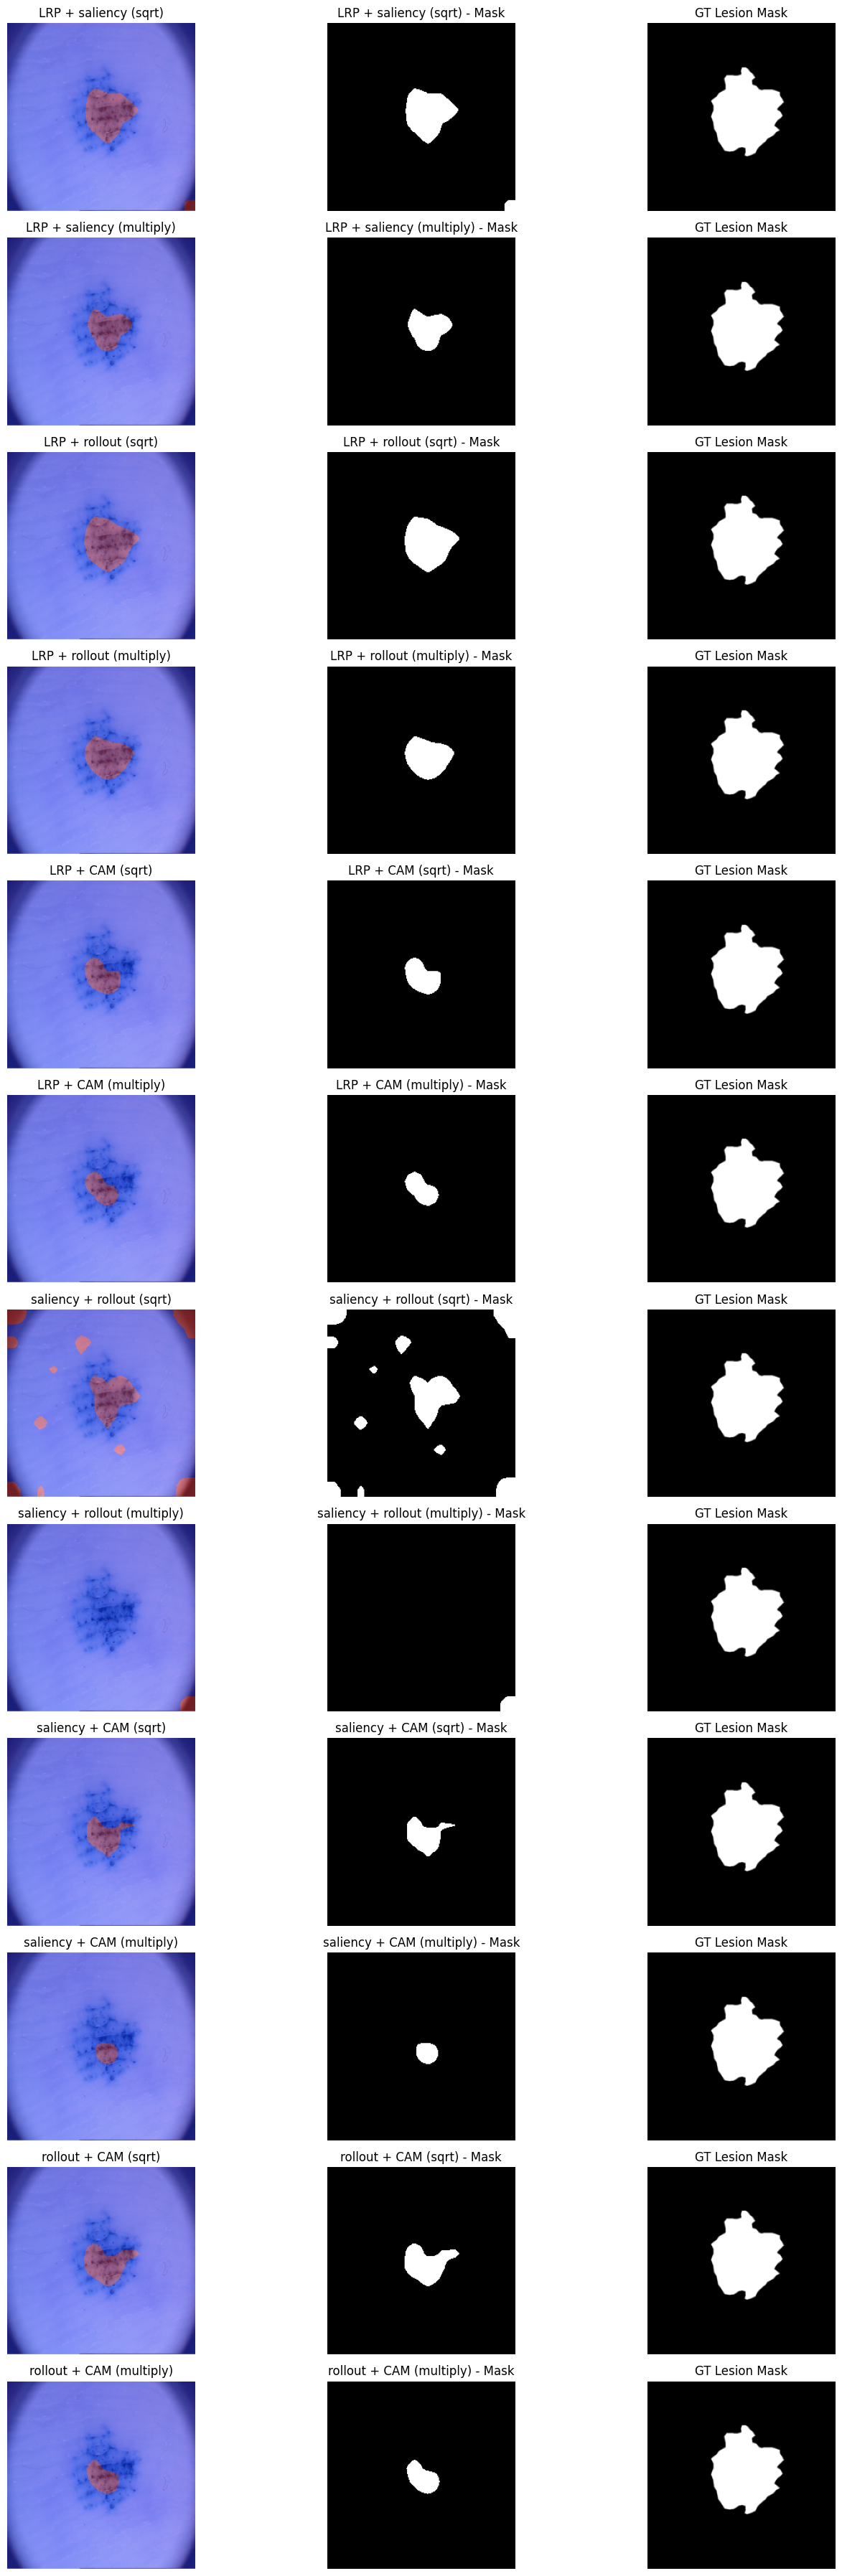

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

folder2='./test'
# Ensure the folder exists
os.makedirs(folder2, exist_ok=True)


# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method1, method2, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attr1 = method1(input_image).reshape(1, 1, 14, 14).to(device)
    attr2 = method2(input_image).reshape(1, 1, 14, 14).to(device)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attr1 * attr2)
    elif combine_method == 'multiply':
        combined_attr = attr1 * attr2

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

# Example usage
def visualize_combined_methods(input_image, method1_name, method2_name, class_index, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    method1 = methods[method1_name]
    method2 = methods[method2_name]

    return combine_and_visualize_attributions(input_image, lambda img: method1(img, class_index), lambda img: method2(img, class_index), combine_method, use_thresholding)

# Function to visualize all 2-way combinations
def visualize_all_combinations(input_image, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 2))

    # Determine the predicted class index
    output = model_A(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()
    print(f"Predicted class index: {class_index}")

    results = []
    for combo in combinations_list:
        for combine_method in combine_methods:
            print(f"Visualizing {' + '.join(combo)} with {combine_method}")
            vis, mask = visualize_combined_methods(input_image, combo[0], combo[1], class_index, combine_method, use_thresholding)
            results.append((f"{' + '.join(combo)} ({combine_method})", vis, mask))

    return results

# Load images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_path = r'/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images/IMD008/IMD008_Dermoscopic_Image/IMD008.bmp'
mask_path = r'/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images/IMD008/IMD008_lesion/IMD008_lesion.bmp'

# image_path = r'C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset\IMD008\IMD008_Dermoscopic_Image\IMD008.bmp'
# mask_path = r'C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset\IMD008\IMD008_lesion\IMD008_lesion.bmp'
image = Image.open(image_path).convert('RGB')
lesion_mask = Image.open(mask_path).convert('L')

im = transform(image).cuda()
lesion_mask = transforms.Resize((224, 224))(lesion_mask)
lesion_mask = np.array(lesion_mask)

# Visualize all combinations
results = visualize_all_combinations(im, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=True)

# Save the results
for name, result, mask in results:
    save_path = os.path.join(folder2, f"{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    mask_path = os.path.join(folder2, f"{name}_mask.png")
    cv2.imwrite(mask_path, mask * 255)  # Save binary mask

# Display the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results)*3))
for ax_row, (name, result, mask) in zip(axes, results):
    ax_row[0].imshow(result)
    ax_row[0].set_title(name)
    ax_row[0].axis('off')

    ax_row[1].imshow(mask, cmap='gray')
    ax_row[1].set_title(f"{name} - Mask")
    ax_row[1].axis('off')

    ax_row[2].imshow(lesion_mask, cmap='gray')
    ax_row[2].set_title("GT Lesion Mask")
    ax_row[2].axis('off')

plt.tight_layout()
plt.show()


Predicted class index: 0
Visualizing LRP + saliency with sqrt
Visualizing LRP + saliency with multiply
Visualizing LRP + rollout with sqrt
Visualizing LRP + rollout with multiply
Visualizing LRP + CAM with sqrt
Visualizing LRP + CAM with multiply
Visualizing saliency + rollout with sqrt
Visualizing saliency + rollout with multiply
Visualizing saliency + CAM with sqrt
Visualizing saliency + CAM with multiply
Visualizing rollout + CAM with sqrt
Visualizing rollout + CAM with multiply


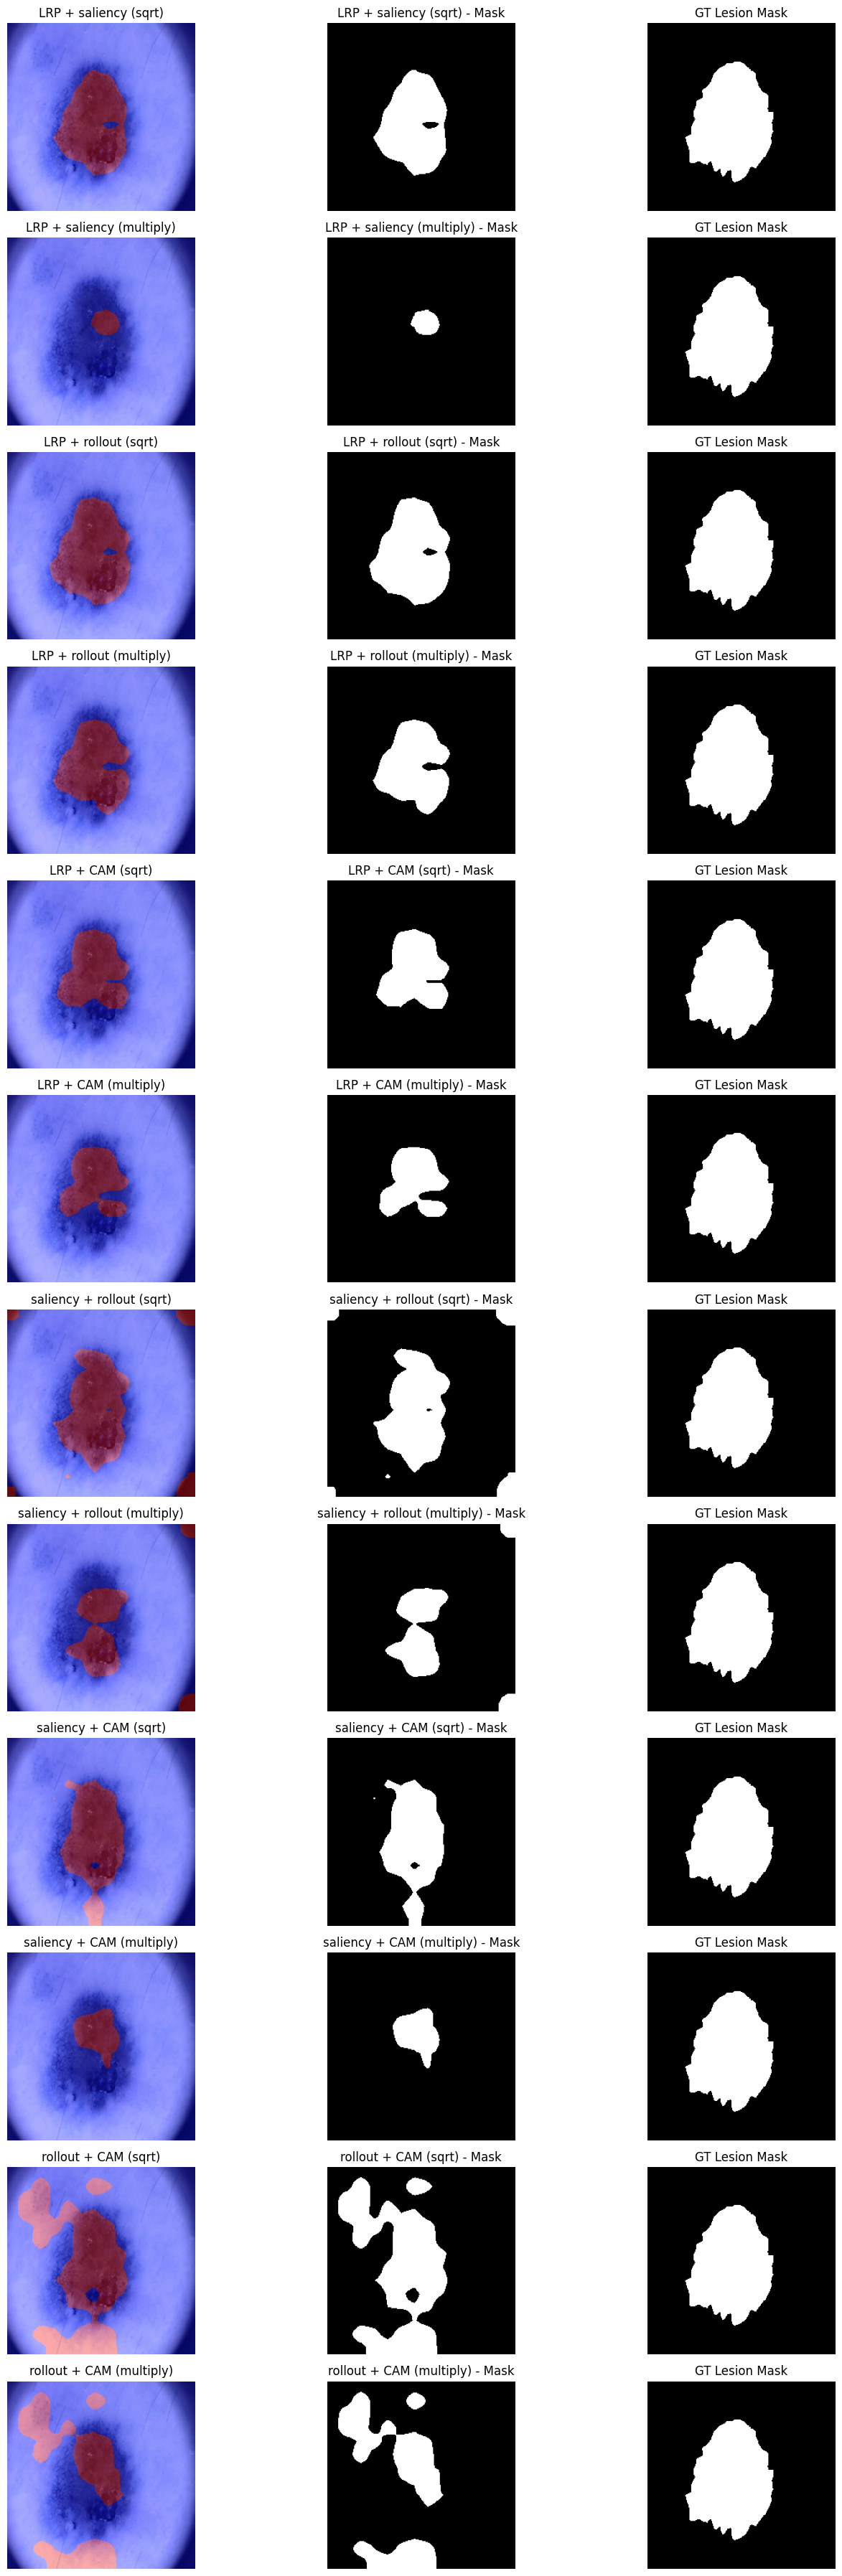

In [ ]:
if len(cleaned_images) >= 10 and len(cleaned_lesions) >= 10:
    tenth_image = cleaned_images[9]  # Python indexing starts at 0
    tenth_lesion = cleaned_lesions[9]

    image = Image.fromarray(tenth_image).convert('RGB')  # Convert to PIL Image
    lesion_mask = Image.fromarray(tenth_lesion).convert('L')  # Convert to grayscale

    im = transform(image).cuda()
    lesion_mask = transforms.Resize((224, 224))(lesion_mask)
    lesion_mask = np.array(lesion_mask)

    lesion_mask = (lesion_mask > 0).astype(np.uint8)  # Now lesion_mask is 0/1


    results = visualize_all_combinations(im, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=True)

    fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results) * 3))
    for ax_row, (name, result, mask) in zip(axes, results):
        ax_row[0].imshow(result)
        ax_row[0].set_title(name)
        ax_row[0].axis('off')

        ax_row[1].imshow(mask, cmap='gray')
        ax_row[1].set_title(f"{name} - Mask")
        ax_row[1].axis('off')

        ax_row[2].imshow(lesion_mask, cmap='gray')
        ax_row[2].set_title("GT Lesion Mask")
        ax_row[2].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("The dataset has fewer than 10 images or lesions.")


In [ ]:
test_model_sample_by_sample(model_A, cleaned_images, cleaned_labels)
test_model_sample_by_sample(model_B, cleaned_images, cleaned_labels)

Sample 1: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 1: torch.Size([3, 224, 224])
Sample 2: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 2: torch.Size([3, 224, 224])
Sample 3: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 3: torch.Size([3, 224, 224])
Sample 4: Prediction = 1, GT Label = 1, Correct = True
Gradients shape for Sample 4: torch.Size([3, 224, 224])
Sample 5: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 5: torch.Size([3, 224, 224])
Sample 6: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 6: torch.Size([3, 224, 224])
Sample 7: Prediction = 0, GT Label = 0, Correct = True
Gradients shape for Sample 7: torch.Size([3, 224, 224])
Sample 8: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 8: torch.Size([3, 224, 224])
Sample 9: Prediction = 2, GT Label = 2, Correct = True
Gradients shape for Sample 9: torch.Size([3, 224, 224])
S

Image 0: Predicted Class = 0, True Class = 0
Image 1: Predicted Class = 2, True Class = 2
Image 2: Predicted Class = 0, True Class = 0
Image 3: Predicted Class = 1, True Class = 1
Image 4: Predicted Class = 0, True Class = 0
Image 5: Predicted Class = 0, True Class = 0
Image 6: Predicted Class = 0, True Class = 0
Image 7: Predicted Class = 2, True Class = 2
Image 8: Predicted Class = 2, True Class = 2
Image 9: Predicted Class = 1, True Class = 1
Image 10: Predicted Class = 2, True Class = 2
Image 11: Predicted Class = 2, True Class = 2
Image 12: Predicted Class = 1, True Class = 0
Image 13: Predicted Class = 2, True Class = 2
Image 14: Predicted Class = 0, True Class = 0
Image 15: Predicted Class = 0, True Class = 0
Image 16: Predicted Class = 0, True Class = 0
Image 17: Predicted Class = 0, True Class = 0
Image 18: Predicted Class = 1, True Class = 1
Image 19: Predicted Class = 1, True Class = 1
Image 20: Predicted Class = 1, True Class = 1
Image 21: Predicted Class = 1, True Class = 

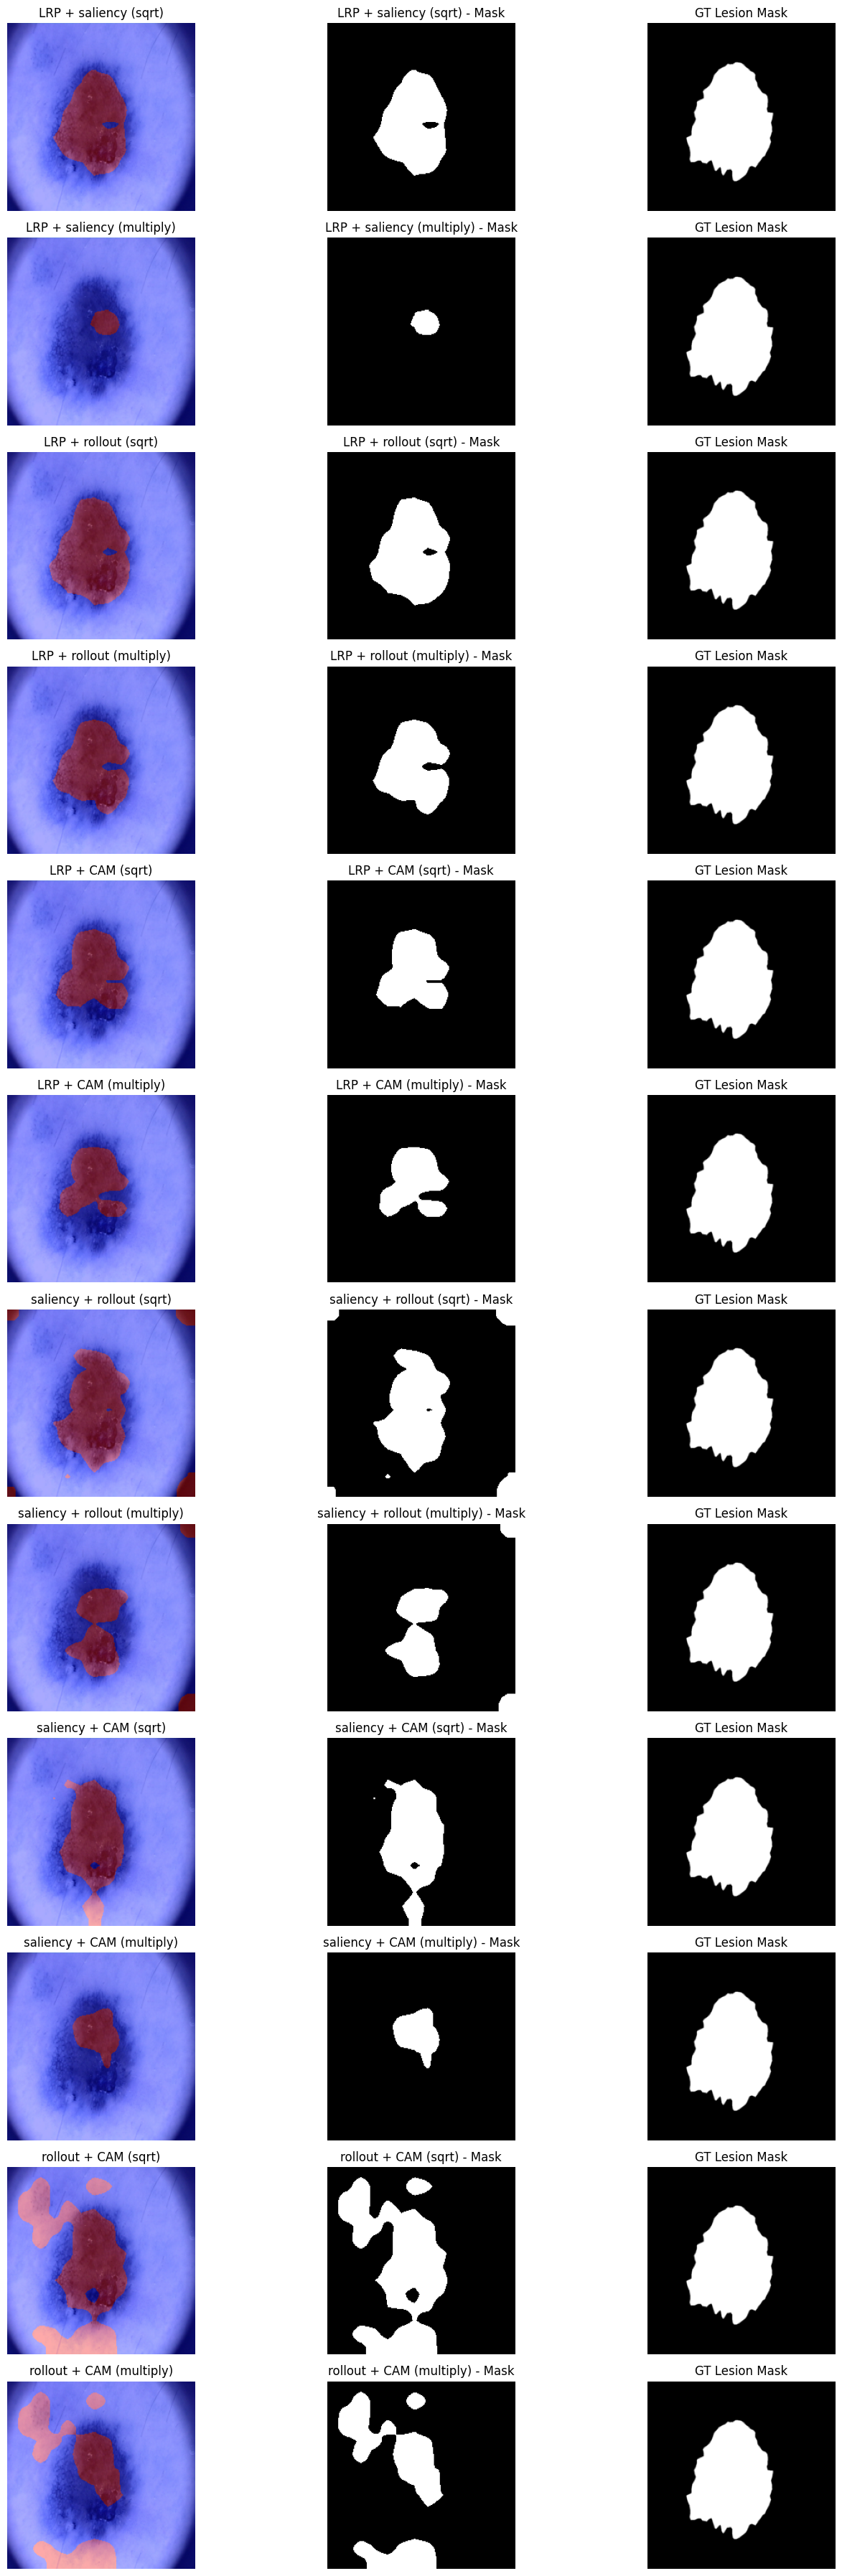

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Create the folder to save the results
output_folder = "2way_folder"
os.makedirs(output_folder, exist_ok=True)

# Initialize variables for accuracy statistics
correct_predictions = 0
total_predictions = 0
all_results = []

# First loop: Compute accuracy statistics
for idx, (image_data, lesion_data) in enumerate(zip(cleaned_images, cleaned_lesions)):
    image = Image.fromarray(image_data).convert('RGB')  # Convert to PIL Image

    im = val_test_transform(image).cuda()

    # Get the model's predicted class
    output = model_B(im.unsqueeze(0))
    predicted_class = output.argmax().item()

    # Assume `true_class` is available from ground truth data
    true_class = cleaned_labels[idx]  # Replace `labels` with your ground truth label array

    # Update statistics
    if predicted_class == true_class:
        correct_predictions += 1
    total_predictions += 1

    print(f"Image {idx}: Predicted Class = {predicted_class}, True Class = {true_class}")

# Calculate and display overall accuracy
overall_accuracy = 100 * correct_predictions / total_predictions
print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")

# Second loop: Generate visualizations, compute metrics, and save pairs
for idx, (image_data, lesion_data) in enumerate(zip(cleaned_images, cleaned_lesions)):
    image = Image.fromarray(image_data).convert('RGB')  # Convert to PIL Image
    lesion_mask = Image.fromarray(lesion_data).convert('L')  # Convert to grayscale

    im = val_test_transform(image).cuda()
    lesion_mask = transforms.Resize((224, 224))(lesion_mask)
    lesion_mask = np.array(lesion_mask)

    # Visualize all combinations
    results = visualize_all_combinations(im, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=True)

    for name, result, mask in results:
        # Compute evaluation metrics
        intersection = np.logical_and(lesion_mask, mask)
        union = np.logical_or(lesion_mask, mask)
        jaccard = np.sum(intersection) / np.sum(union)
        tp = np.sum(intersection)
        fp = np.sum(mask) - tp
        fn = np.sum(lesion_mask) - tp
        f1 = 2 * tp / (2 * tp + fp + fn)
        pixel_accuracy = np.sum(intersection) / np.sum(lesion_mask)

        all_results.append({
            "Image Index": idx,
            "Method": name,
            "Jaccard Index (IoU)": jaccard,
            "F1 Score": f1,
            "Pixel Accuracy": pixel_accuracy
        })

        # Save the results
        result_image = Image.fromarray((result * 255).astype(np.uint8))  # Scale result to [0, 255] for saving
        result_mask = Image.fromarray((mask * 255).astype(np.uint8))
        gt_mask = Image.fromarray((lesion_mask * 255).astype(np.uint8))

        # Save to 2way_folder with appropriate names
        result_image.save(os.path.join(output_folder, f"image_{idx}_{name}.png"))
        result_mask.save(os.path.join(output_folder, f"mask_{idx}_{name}.png"))
        gt_mask.save(os.path.join(output_folder, f"gt_mask_{idx}.png"))

# Show an example result
if all_results:
    print("Example result:")
    print(all_results[0])

# Display results for the 10th entry if available
if len(cleaned_images) >= 10 and len(cleaned_lesions) >= 10:
    tenth_image = cleaned_images[9]
    tenth_lesion = cleaned_lesions[9]

    image = Image.fromarray(tenth_image).convert('RGB')  # Convert to PIL Image
    lesion_mask = Image.fromarray(tenth_lesion).convert('L')  # Convert to grayscale

    im = transform(image).cuda()
    lesion_mask = transforms.Resize((224, 224))(lesion_mask)
    lesion_mask = np.array(lesion_mask)

    results = visualize_all_combinations(im, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=True)

    fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results) * 3))
    for ax_row, (name, result, mask) in zip(axes, results):
        ax_row[0].imshow(result)
        ax_row[0].set_title(name)
        ax_row[0].axis('off')

        ax_row[1].imshow(mask, cmap='gray')
        ax_row[1].set_title(f"{name} - Mask")
        ax_row[1].axis('off')

        ax_row[2].imshow(lesion_mask, cmap='gray')
        ax_row[2].set_title("GT Lesion Mask")
        ax_row[2].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("The dataset has fewer than 10 images or lesions.")


In [ ]:
results_df = pd.DataFrame(all_results)
csv_path = "metrics_results_2WAY.csv"
results_df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")


print("Statistics by Method and Combine Method:")
stats = results_df.groupby("Method")[["Jaccard Index (IoU)", "F1 Score", "Pixel Accuracy"]].mean()
print(stats)


Results saved to metrics_results_2WAY.csv
Statistics by Method and Combine Method:
                               Jaccard Index (IoU)  F1 Score  Pixel Accuracy
Method                                                                      
LRP + CAM (multiply)                      0.125819  0.001072        0.000537
LRP + CAM (sqrt)                          0.182260  0.001594        0.000799
LRP + rollout (multiply)                  0.384057  0.003340        0.001674
LRP + rollout (sqrt)                      0.538628  0.004895        0.002456
LRP + saliency (multiply)                 0.269708  0.002308        0.001156
LRP + saliency (sqrt)                     0.484625  0.004331        0.002172
rollout + CAM (multiply)                  0.142780  0.001249        0.000626
rollout + CAM (sqrt)                      0.184930  0.001667        0.000836
saliency + CAM (multiply)                 0.120675  0.001018        0.000510
saliency + CAM (sqrt)                     0.185543  0.001621        0.

# 3WAY

Predicted class index: 0
Visualizing LRP + saliency + rollout with sqrt
Visualizing LRP + saliency + rollout with multiply
Visualizing LRP + saliency + CAM with sqrt
Visualizing LRP + saliency + CAM with multiply
Visualizing LRP + rollout + CAM with sqrt
Visualizing LRP + rollout + CAM with multiply
Visualizing saliency + rollout + CAM with sqrt
Visualizing saliency + rollout + CAM with multiply


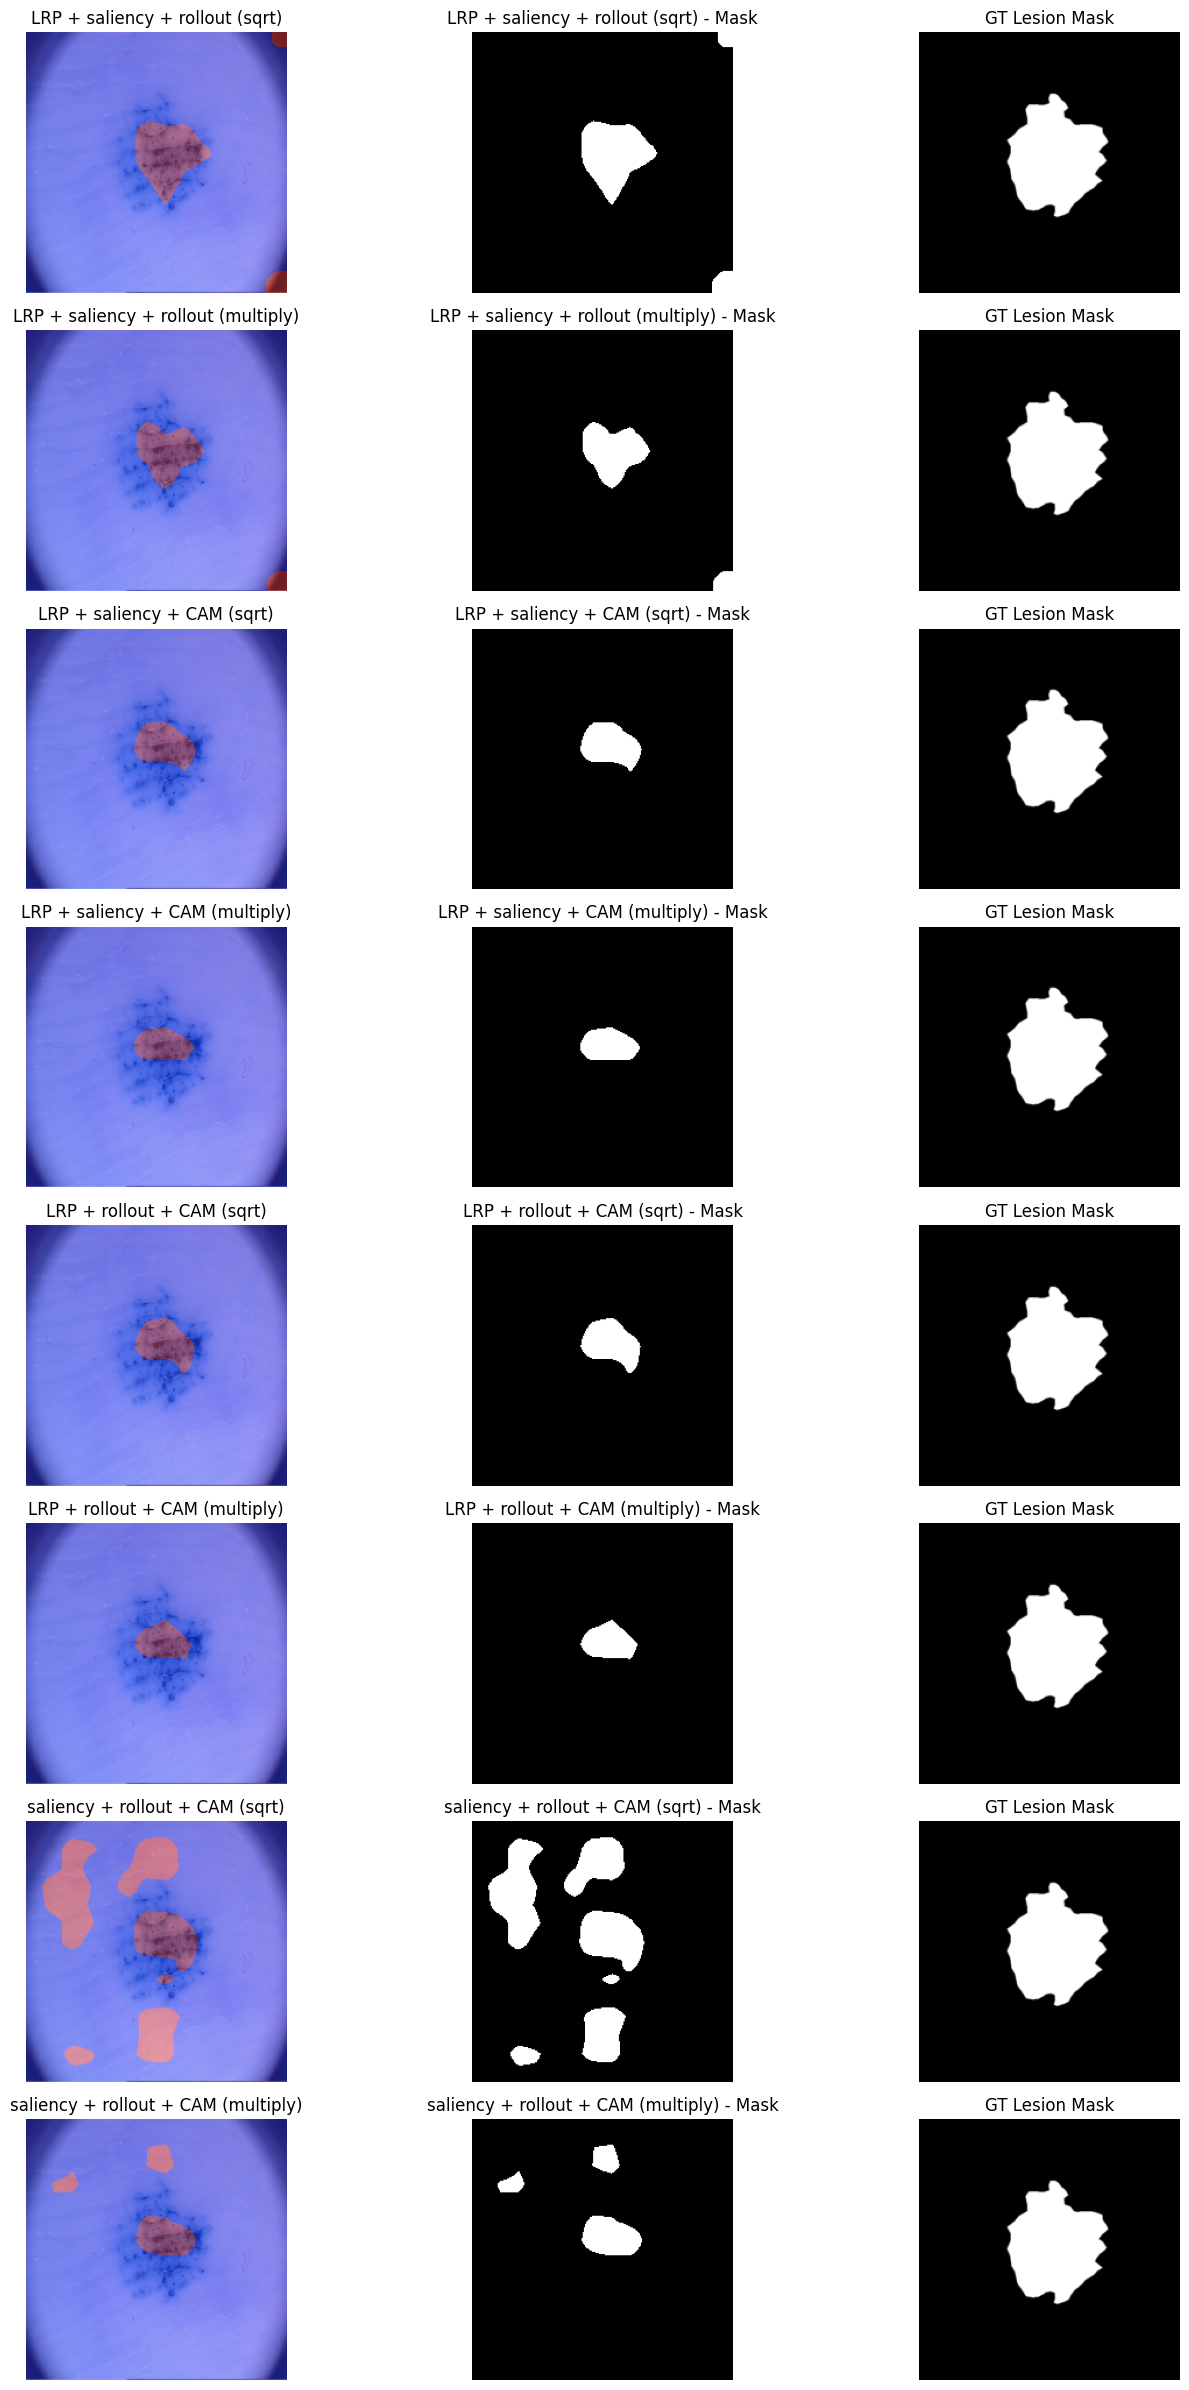

In [ ]:
folder2='./test'
os.makedirs(folder2, exist_ok=True)


# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, methods, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attributions = []
    for method in methods:
        if method.__name__ in ['generate_saliency', 'generate_CAM', 'generate_LRP']:
            attr = method(input_image, class_index=1).reshape(1, 1, 14, 14).to(device)  # class_index is set to 1 for demonstration
        else:
            attr = method(input_image).reshape(1, 1, 14, 14).to(device)
        attributions.append(attr)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attributions[0] * attributions[1] * attributions[2])
    elif combine_method == 'multiply':
        combined_attr = attributions[0] * attributions[1] * attributions[2]

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

# Example usage
def visualize_combined_methods(input_image, method_names, class_index, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    selected_methods = [methods[name] for name in method_names]

    return combine_and_visualize_attributions(input_image, selected_methods, combine_method, use_thresholding)

# Function to visualize all 3-way combinations
def visualize_all_combinations(input_image, combine_methods=['sqrt', 'multiply'], use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 3))

    # Determine the predicted class index
    output = model_A(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()
    print(f"Predicted class index: {class_index}")

    results = []
    for combo in combinations_list:
        for combine_method in combine_methods:
            print(f"Visualizing {' + '.join(combo)} with {combine_method}")
            vis, mask = visualize_combined_methods(input_image, combo, class_index, combine_method, use_thresholding)
            results.append((f"{' + '.join(combo)} ({combine_method})", vis, mask))

    return results

# Load images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_path = r'/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images/IMD008/IMD008_Dermoscopic_Image/IMD008.bmp'
mask_path = r'/content/Transformer-Explainability/PH2Dataset/PH2 Dataset images/IMD008/IMD008_lesion/IMD008_lesion.bmp'

# image_path = r'C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset\IMD008\IMD008_Dermoscopic_Image\IMD008.bmp'
# mask_path = r'C:\VitMix\Transformer-Explainability\PH2Dataset\PH2_Dataset\IMD008\IMD008_lesion\IMD008_lesion.bmp'
image = Image.open(image_path).convert('RGB')
lesion_mask = Image.open(mask_path).convert('L')

im = transform(image).cuda()
lesion_mask = transforms.Resize((224, 224))(lesion_mask)
lesion_mask = np.array(lesion_mask)

# Visualize all combinations
results = visualize_all_combinations(im, combine_methods=['sqrt', 'multiply'], use_thresholding=True)

# Save the results
for name, result, mask in results:
    save_path = os.path.join(folder2, f"{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    mask_path = os.path.join(folder2, f"{name}_mask.png")
    cv2.imwrite(mask_path, mask * 255)  # Save binary mask

# Display the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results)*3))
for ax_row, (name, result, mask) in zip(axes, results):
    ax_row[0].imshow(result)
    ax_row[0].set_title(name)
    ax_row[0].axis('off')

    ax_row[1].imshow(mask, cmap='gray')
    ax_row[1].set_title(f"{name} - Mask")
    ax_row[1].axis('off')

    ax_row[2].imshow(lesion_mask, cmap='gray')
    ax_row[2].set_title("GT Lesion Mask")
    ax_row[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Ensure the directory exists
output_dir = '3way_folder'
os.makedirs(output_dir, exist_ok=True)

# List to store results
all_results_3way = []

# Iterate over images and lesions
for idx, (image_data, lesion_data) in enumerate(zip(cleaned_images, cleaned_lesions)):
    # Convert numpy arrays to PIL Images
    image = Image.fromarray(image_data).convert('RGB')
    lesion_mask = Image.fromarray(lesion_data).convert('L')  # Grayscale

    # Apply transformations
    im = val_test_transform(image).cuda()
    lesion_mask_resized = transforms.Resize((224, 224))(lesion_mask)
    lesion_mask_np = np.array(lesion_mask_resized)
    lesion_mask_binary = (lesion_mask_np > 0).astype(np.uint8)  # Convert to binary mask

    # Visualize and evaluate
    results = visualize_all_combinations(im, use_thresholding=True)

    for name, result, mask in results:
        # Compute metrics
        intersection = np.logical_and(lesion_mask_binary, mask)
        union = np.logical_or(lesion_mask_binary, mask)
        jaccard = np.sum(intersection) / np.sum(union)
        tp = np.sum(intersection)
        fp = np.sum(mask) - tp
        fn = np.sum(lesion_mask_binary) - tp
        f1 = 2 * tp / (2 * tp + fp + fn)
        pixel_accuracy = np.sum(intersection) / np.sum(lesion_mask_binary)

        # Save image, mask, and GT mask
        output_prefix = f"Image_{idx}_Method_{name}"
        image.save(os.path.join(output_dir, f"{output_prefix}_image.png"))
        Image.fromarray(mask * 255).convert('L').save(os.path.join(output_dir, f"{output_prefix}_mask.png"))
        Image.fromarray(lesion_mask_binary * 255).convert('L').save(os.path.join(output_dir, f"{output_prefix}_gt_mask.png"))

        # Append results
        all_results_3way.append({
            "Image Index": idx,
            "Method": name,
            "Jaccard Index (IoU)": jaccard,
            "F1 Score": f1,
            "Pixel Accuracy": pixel_accuracy
        })

# Show an example result
if all_results_3way:
    print("Example result:")
    print(all_results_3way[0])


Predicted class index: 0
Visualizing LRP + saliency + rollout with sqrt
Visualizing LRP + saliency + rollout with multiply
Visualizing LRP + saliency + CAM with sqrt
Visualizing LRP + saliency + CAM with multiply
Visualizing LRP + rollout + CAM with sqrt
Visualizing LRP + rollout + CAM with multiply
Visualizing saliency + rollout + CAM with sqrt
Visualizing saliency + rollout + CAM with multiply
Predicted class index: 2
Visualizing LRP + saliency + rollout with sqrt
Visualizing LRP + saliency + rollout with multiply
Visualizing LRP + saliency + CAM with sqrt
Visualizing LRP + saliency + CAM with multiply
Visualizing LRP + rollout + CAM with sqrt
Visualizing LRP + rollout + CAM with multiply
Visualizing saliency + rollout + CAM with sqrt
Visualizing saliency + rollout + CAM with multiply
Predicted class index: 0
Visualizing LRP + saliency + rollout with sqrt
Visualizing LRP + saliency + rollout with multiply
Visualizing LRP + saliency + CAM with sqrt
Visualizing LRP + saliency + CAM wit

In [ ]:
save_and_display_results("metrics_results_3WAY.csv", all_results_3way)

Results saved to metrics_results_3WAY.csv
Statistics by Method and Combine Method:
                                     Jaccard Index (IoU)  F1 Score  \
Method                                                               
LRP + rollout + CAM (multiply)                  0.121853  0.189904   
LRP + rollout + CAM (sqrt)                      0.193512  0.276272   
LRP + saliency + CAM (multiply)                 0.116234  0.184894   
LRP + saliency + CAM (sqrt)                     0.195514  0.283415   
LRP + saliency + rollout (multiply)             0.220066  0.322526   
LRP + saliency + rollout (sqrt)                 0.434724  0.568628   
saliency + rollout + CAM (multiply)             0.091010  0.148098   
saliency + rollout + CAM (sqrt)                 0.164434  0.242653   

                                     Pixel Accuracy  
Method                                               
LRP + rollout + CAM (multiply)             0.135732  
LRP + rollout + CAM (sqrt)                 0.225919  
